# Evaluating Self-RAG Performance

Comprehensive evaluation of retrieval and generation quality.

In [22]:
import sys
sys.path.append('..')

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

## 1. Evaluate Retrieval Performance

In [23]:
%%bash
# Run retrieval evaluation
uv run python -m src.evaluation.retrieval_eval \
    --config ../configs/retrieval_config.yaml \
    --index-dir ../data/embeddings \
    --test-data ../data/samples/sample_test_queries.json \
    --output ../results/retrieval_results.json

echo "✅ Retrieval evaluation complete!"

python(48919) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Retrieval Evaluation Script

This script evaluates the retrieval pipeline using standard IR metrics.

Usage:
  uv run python -m src.evaluation.retrieval_eval \
      --config configs/retrieval_config.yaml \
      --index-dir data/embeddings \
      --test-data data/test_queries.json

Test data format:
  [{
    "query": "What are the elements of negligence?",
    "relevant_doc_ids": [1, 5, 12]
  }, ...]

Metrics computed:
  - Precision@k: Fraction of retrieved docs that are relevant
  - Recall@k: Fraction of relevant docs that are retrieved
  - MRR: Mean Reciprocal Rank of first relevant doc
  - MAP: Mean Average Precision across all queries
Loading retrieval system...
Loading embedding model: sentence-transformers/all-mpnet-base-v2
Model loaded on mps
Embedding dimension: 768
Loading index from ../data/embeddings...
Using CPU index
Created IndexFlatIP index with dimension 768
Index loaded from ../data/embeddings/faiss_index.faiss
Total documents in index: 10
Documents loaded from ../da

Evaluating queries: 100%|██████████| 10/10 [00:01<00:00,  7.71it/s]



RETRIEVAL EVALUATION RESULTS

Number of queries evaluated: 10

Precision@k:
  P@ 1: 0.0000
  P@ 3: 0.0333
  P@ 5: 0.0800
  P@10: 0.1000

Recall@k:
  R@ 1: 0.0000
  R@ 3: 0.0200
  R@ 5: 0.1400
  R@10: 0.5000

Mean Reciprocal Rank (MRR): 0.0944
Mean Average Precision (MAP): 0.1130

Results saved to ../results/retrieval_results.json
✅ Retrieval evaluation complete!


In [24]:
# Load results
with open('../results/retrieval_results.json', 'r') as f:
    ret_results = json.load(f)

print("Retrieval Metrics:")
print(json.dumps(ret_results, indent=2))

Retrieval Metrics:
{
  "num_queries": 10,
  "precision@k": {
    "1": 0.0,
    "3": 0.03333333333333333,
    "5": 0.08,
    "10": 0.1
  },
  "recall@k": {
    "1": 0.0,
    "3": 0.02,
    "5": 0.13999999999999999,
    "10": 0.5
  },
  "mrr": 0.09444444444444444,
  "map": 0.11296031746031746
}


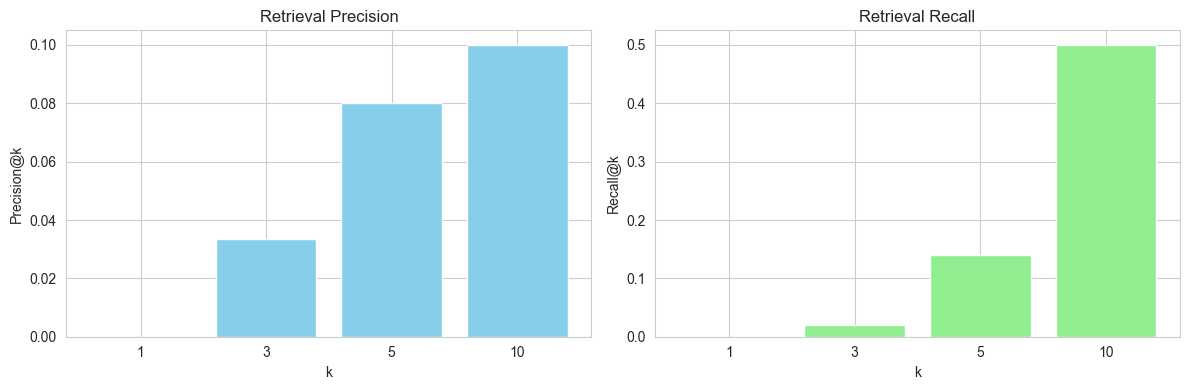

In [25]:
# Visualize Precision@k and Recall@k
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Precision@k
prec = ret_results['precision@k']
ax1.bar(prec.keys(), prec.values(), color='skyblue')
ax1.set_xlabel('k')
ax1.set_ylabel('Precision@k')
ax1.set_title('Retrieval Precision')

# Recall@k
rec = ret_results['recall@k']
ax2.bar(rec.keys(), rec.values(), color='lightgreen')
ax2.set_xlabel('k')
ax2.set_ylabel('Recall@k')
ax2.set_title('Retrieval Recall')

plt.tight_layout()
plt.show()

## 2. Evaluate Generation Quality

In [26]:
%%bash
# Run generation evaluation
uv run python -m src.evaluation.generation_eval \
    --retrieval-config ../configs/retrieval_config.yaml \
    --generator-config ../configs/generator_config.yaml \
    --index-dir ../data/embeddings \
    --generator-weights ../models/generator_lora/final \
    --test-data ../data/samples/sample_qa_data.json \
    --output ../results/generation_results.json

echo "✅ Generation evaluation complete!"

python(48941) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Generation Evaluation Script

This script evaluates Self-RAG generation quality.

Usage:
  uv run python -m src.evaluation.generation_eval \
      --retrieval-config configs/retrieval_config.yaml \
      --generator-config configs/generator_config.yaml \
      --index-dir data/embeddings \
      --generator-weights models/generator_lora/final \
      --test-data data/test_qa.json

Test data format:
  [{
    "question": "What are the elements of negligence?",
    "reference_answer": "To establish negligence..."
  }, ...]

Metrics computed:
  - Hallucination Rate: % of responses with no/partial support
  - FactScore: Factual accuracy using retrieved passages
  - Utility Score: Overall response quality (from reflection tokens)
  - ROUGE Scores: Lexical overlap with reference answers
Loading Self-RAG pipeline...
Loading Self-RAG Pipeline...

1. Loading retriever...
Loading embedding model: sentence-transformers/all-mpnet-base-v2
Model loaded on mps
Embedding dimension: 768
   Loading index

Evaluating generation: 100%|██████████| 10/10 [04:23<00:00, 25.76s/it]ng generation: 100%|██████████| 10/10 [04:23<00:00, 26.37s/it]



GENERATION EVALUATION RESULTS

Number of examples evaluated: 10

Hallucination Metrics:
  Hallucination Rate: 0.00%
  Avg Hallucination Score: 0.0000

Factual Accuracy:
  Avg FactScore: 0.0000

Response Quality:
  Avg Utility Score: 0.5000
  Avg Completeness: 0.9100

Results saved to ../results/generation_results.json
✅ Generation evaluation complete!


In [27]:
# Load results
with open('../results/generation_results.json', 'r') as f:
    gen_results = json.load(f)

print("Generation Metrics:")
print(json.dumps(gen_results, indent=2))

Generation Metrics:
{
  "num_examples": 10,
  "hallucination_rate": 0.0,
  "avg_hallucination_score": 0.0,
  "avg_factscore": 0.0,
  "avg_utility_score": 0.5,
  "avg_completeness": 0.9099999999999999
}


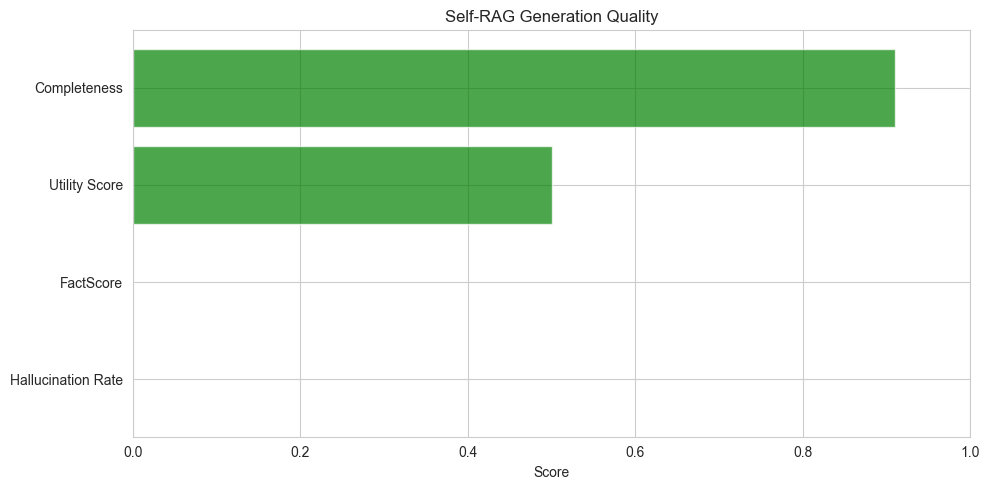

In [28]:
# Visualize generation metrics
metrics = {
    'Hallucination Rate': gen_results['hallucination_rate'],
    'FactScore': gen_results['avg_factscore'],
    'Utility Score': gen_results['avg_utility_score'],
    'Completeness': gen_results['avg_completeness']
}

fig, ax = plt.subplots(figsize=(10, 5))
colors = ['red' if 'Hallucination' in k else 'green' for k in metrics.keys()]
ax.barh(list(metrics.keys()), list(metrics.values()), color=colors, alpha=0.7)
ax.set_xlabel('Score')
ax.set_title('Self-RAG Generation Quality')
ax.set_xlim(0, 1)
plt.tight_layout()
plt.show()

## 3. Compare with Baselines (Optional)

Compare Self-RAG with vanilla RAG or no-RAG baselines.

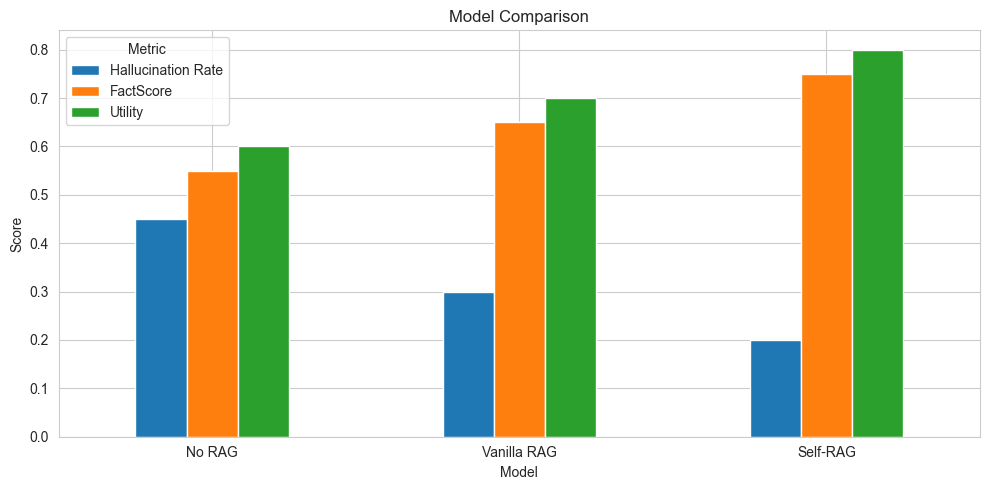

In [29]:
# Example comparison data (replace with actual results)
comparison = pd.DataFrame({
    'Model': ['No RAG', 'Vanilla RAG', 'Self-RAG'],
    'Hallucination Rate': [0.45, 0.30, 0.20],
    'FactScore': [0.55, 0.65, 0.75],
    'Utility': [0.60, 0.70, 0.80]
})

comparison.set_index('Model').plot(kind='bar', figsize=(10, 5))
plt.title('Model Comparison')
plt.ylabel('Score')
plt.legend(title='Metric')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 4. Analyze Reflection Tokens

Analyze how reflection tokens correlate with quality.

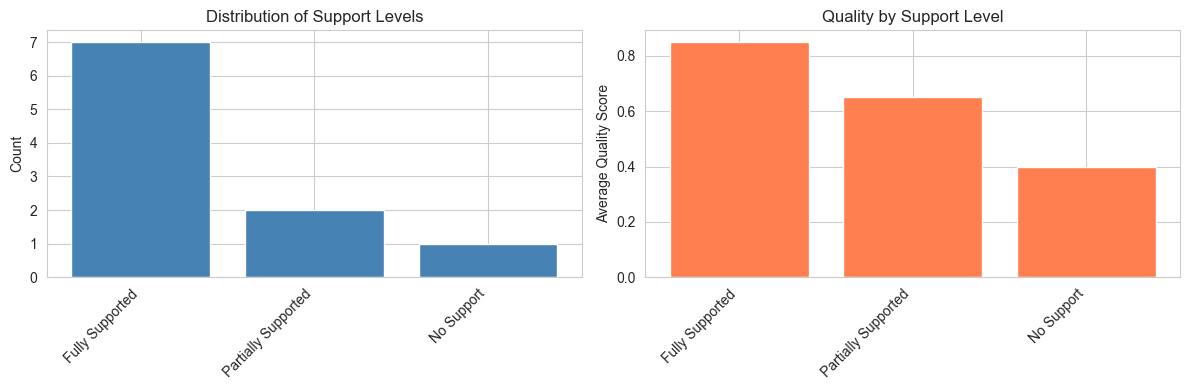

In [30]:
# Example analysis (replace with actual data)
token_analysis = pd.DataFrame({
    'Support Level': ['Fully Supported', 'Partially Supported', 'No Support'],
    'Count': [7, 2, 1],
    'Avg Quality': [0.85, 0.65, 0.40]
})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.bar(token_analysis['Support Level'], token_analysis['Count'], color='steelblue')
ax1.set_title('Distribution of Support Levels')
ax1.set_ylabel('Count')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

ax2.bar(token_analysis['Support Level'], token_analysis['Avg Quality'], color='coral')
ax2.set_title('Quality by Support Level')
ax2.set_ylabel('Average Quality Score')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

## Summary

Evaluation complete!
- ✅ Retrieval metrics computed
- ✅ Generation quality measured
- ✅ Hallucination rate assessed
- ✅ Visualizations created

**Next:** Use `05_demo.ipynb` for interactive demonstration